In [13]:
import math
import numpy as np
import pandas as pd
import scipy.stats as scs
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = 'serif'
import datetime

In [ ]:
'''
股票价格几何布朗运动模拟
'''

In [157]:
#
# 几何布朗运动拟合股票价格
#

def simulate_gbm():
    # model parameters
    S0 = 100.0  # initial index level
    T = 10.0  # time horizon
    start = '2004-09-30' # start time
    r = 0.05  # risk-less short rate
    vol = 0.2  # instantaneous volatility
    
    # caculate end time
    start_datetime = datetime.datetime.strptime(start,'%Y-%m-%d')
    end = datetime.datetime(start_datetime.year+int(T),start_datetime.month,start_datetime.day)

    # simulation parameters
    np.random.seed(250000)
    gbm_dates = pd.DatetimeIndex(start=start,
                                 end=end,
                                 freq='B')
    M = len(gbm_dates)  # time steps
    I = 1  # index level paths
    dt = 1 / 252.  # fixed for simplicity
    df = math.exp(-r * dt)  # discount factor

    # stock price paths
    rand = np.random.standard_normal(M)  # random numbers
    S = np.zeros_like(rand)  # stock matrix
    S[0] = S0  # initial values
    for t in range(1, M):  # stock price paths, 初始值不用随机生成
        # 股票价格过程：几何布朗运动，递推式
        S[t] = S[t - 1] * np.exp((r - vol ** 2 / 2) * dt +
                                 vol * rand[t] * math.sqrt(dt))

    gbm = pd.DataFrame(S, index=gbm_dates, columns=['close'])
    gbm['returns'] = np.log(gbm['close'] / gbm['close'].shift(1))

    # 年化实际波动率rea_vol，收益率平方均值的平方根，此处是expanding式滚动
    gbm['rea_var'] = 252 * np.cumsum(gbm['returns'] ** 2) / np.arange(len(gbm))
    gbm['rea_vol'] = np.sqrt(gbm['rea_var'])
    gbm = gbm.dropna()
    return gbm

In [ ]:
'''
股票价格输入 - 一列date,一列close
'''

In [136]:
def stock_price(input_data,dropna=True):
   
    # 修正字符串日期为datetime
    data = input_data.copy()
    stock_dates = pd.DatetimeIndex(data.index)
    data.index = stock_dates
    
    # 生成收益率序列
    data['returns'] = np.log(data['close'] / data['close'].shift(1))
    
    # 年化实际方差rea_var，收益率平方均值，此处是expanding式滚动
    data['rea_var'] = (data['returns']**2).expanding().mean()*252
    
    # 年化实际波动率rea_vol，收益率平方均值的平方根，此处是expanding式滚动
    data['rea_vol'] = np.sqrt(data['rea_var'])

    if dropna:
        data = data.dropna()

    return data

In [ ]:
'''
股票价格相关序列结果绘图
'''

In [150]:
# 股票价格与均线图

def plot_ma(data):
    plt.figure(figsize=(16,12))
    col = 'close'
    series = data[col]
    series_ma5 = series.rolling(5).mean()
    series_ma21 = series.rolling(21).mean()
    series_ma63 = series.rolling(63).mean()
    plt.plot(series,label=col)
    for period in [5,21,63]: 
        plt.plot(series.rolling(period).mean(),label=col+'MA'+str(period))
    plt.legend(loc=0)
    plt.xlabel('Year')
    plt.ylabel(col)
    plt.grid(True)

In [151]:
# 股票价格、收益率、年化方差、年化波动率结果折线图

def plot_each(data):
    plt.figure(figsize=(16,10))
    for i in range(len(data.columns)):
        col = data.columns[i]
        series = data[col]
        plt.subplot(221+i)
        plt.plot(series,label=col)
        plt.axhline(series.mean(), color='r', ls='dashed')
        plt.legend(loc=4)
        plt.xlabel('Year')
        plt.ylabel(col)
        plt.grid(True)

In [152]:
# 绘制收益率频率分布直方图

def plot_freq_hist(data):
    
    def dN(x, mu, sigma):
        ''' 
        正态分布概率密度函数
        '''
        z = (x - mu) / sigma
        pdf = np.exp(-0.5 * z ** 2) / math.sqrt(2 * math.pi * sigma ** 2)
        return pdf

    plt.figure(figsize=(12, 10))
    x = np.linspace(min(data['returns']), max(data['returns']), 100)
    plt.hist(np.array(data['returns']), bins=50,density=True)
    y = dN(x, np.mean(data['returns']), np.std(data['returns']))
    plt.plot(x, y, linewidth=2)
    plt.xlabel('log returns')
    plt.ylabel('frequency/probability')
    plt.grid(True)

In [153]:
# 绘制收益率与正态分布QQ图

def qqplot_log_return(data):
    sm.qqplot(data['returns'], line='s')
    plt.grid(True)
    plt.xlabel('theoretical quantiles')
    plt.ylabel('sample quantiles')

In [154]:
# 绘制收益率的滚动252天均值、波动率及两者相关关系

def rolling_mean(data):
    rmean = data['returns'].rolling(252).mean()*252
    rvol = data['returns'].rolling(252).std()*np.sqrt(252)
    rcorr = rmean.rolling(252).corr(rvol)
    
    plt.figure(figsize=(16, 10))
    for i in range(3):
        name = ['rolling_mean(252d)','rolling_vol(252d)','rolling_corr(252d)'][i]
        series = [rmean,rvol,rcorr][i]
        plt.subplot(311+i)
        plt.plot(series,label=name)
        plt.legend(loc=0)
        plt.grid(True)
        plt.xlabel('Year')
        plt.ylabel(name)
        plt.axhline(series.mean(),color='r',ls='dashed')

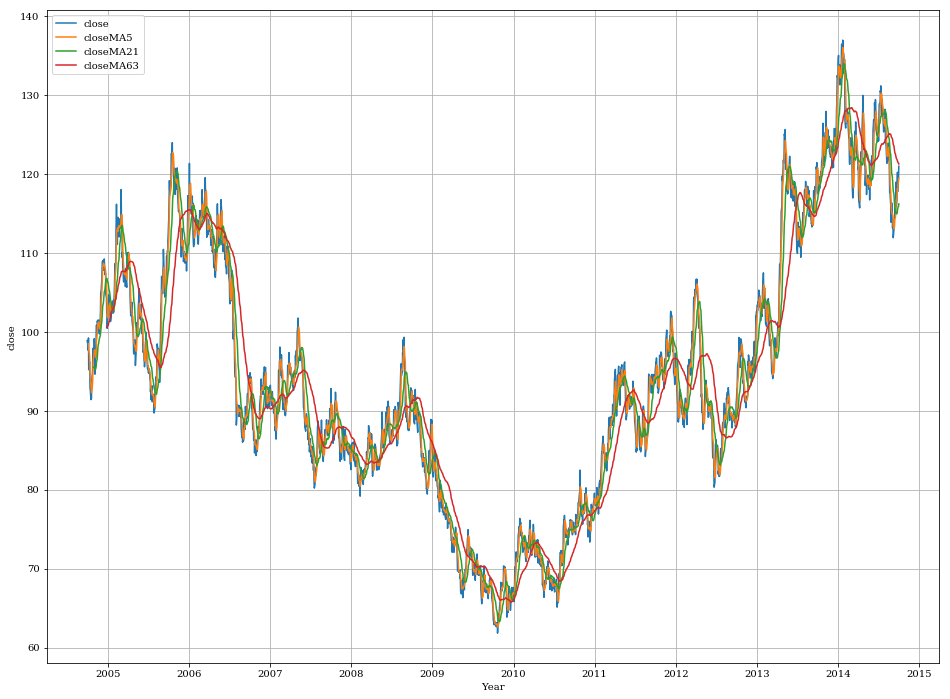

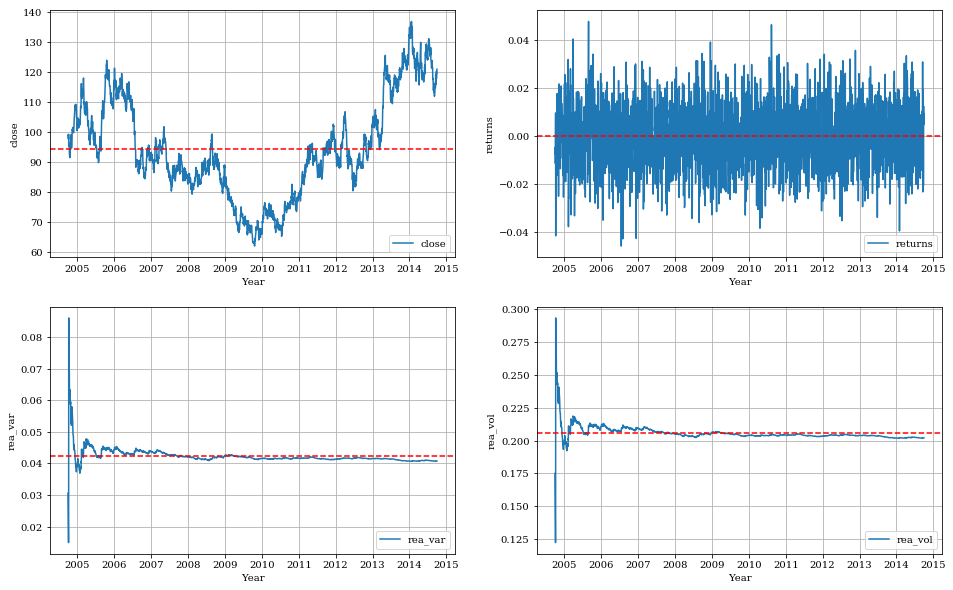

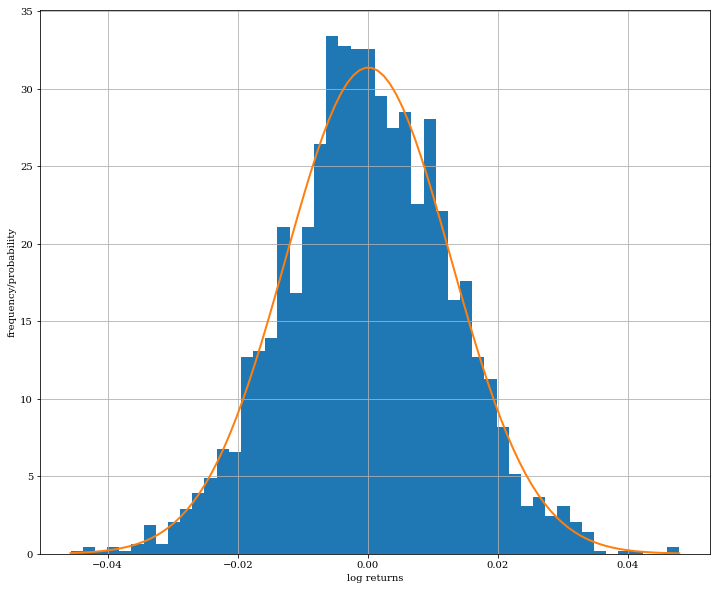

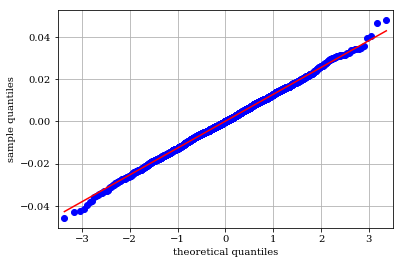

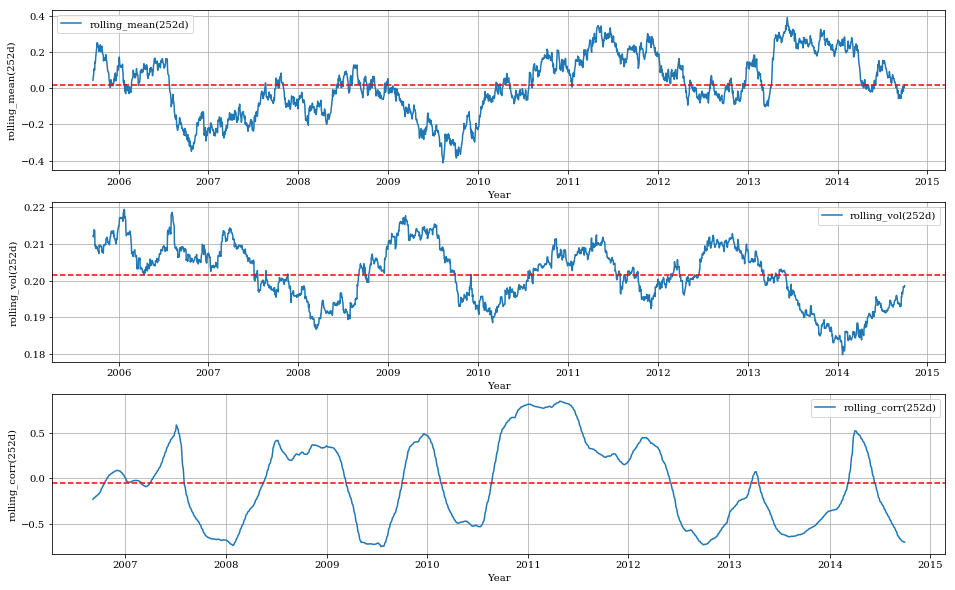

In [158]:
# 数据，收盘价格

# # 输入数据
# data_df = stock_price(pd.read_csv('D:/JUEJINStockDataV1/SZSE.000002.csv',index_col=0)[['close']].copy(),dropna=True)
# 几何布朗运动模拟数据
data_df = simulate_gbm()

plot_ma(data_df)
plot_each(data_df)
plot_freq_hist(data_df)
qqplot_log_return(data_df)
rolling_mean(data_df)